Environment setup and imports

In [1]:
# Install or upgrade
!pip install -q --upgrade transformers statsmodels
!pip install -q minicons

# Core imports
import os, sys, json, gc, re, itertools, random, time
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ML and language modeling
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

# Statistics and modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Print versions so runs are comparable across machines
print("Environment ready:")
print(f"  Python        : {sys.version.split()[0]}")
print(f"  NumPy         : {np.__version__}")
print(f"  Pandas        : {pd.__version__}")
print(f"  PyTorch       : {torch.__version__} (CUDA available: {torch.cuda.is_available()})")
print(f"  Transformers  : {transformers.__version__}")
print(f"  Statsmodels   : {sm.__version__}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Global configuration and reproducibility

In [2]:
# Project configuration
CONFIG = {
    "random_seed": 42,
    "data_dir": "/content/data",
    "results_dir": "/content/results",
    "figures_dir": "/content/figures",
    "models_dir": "/content/models",
    "meco_l1_url": "https://osf.io/3527a/download",
    "meco_l2_url": "https://osf.io/q9h43/download",
    "model_name": "gpt2",
    "min_rt": 50,
    "max_rt": 5000,
    "trim_sd": 3,
    "min_word_len": 2,
    "exclude_punct": True,
    "sample_n": None,
}

# Ensure directories exist
for p in [CONFIG["data_dir"], CONFIG["results_dir"], CONFIG["figures_dir"], CONFIG["models_dir"]]:
    Path(p).mkdir(parents=True, exist_ok=True)

# Reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["random_seed"])

# Compute device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


Convert R data (.rda) to CSV with pyreadr

In [3]:
#  Install dependency
!pip install -q pyreadr

import os
from pathlib import Path
import pyreadr
import pandas as pd

# Input .rda paths
l1_rda = "/content/joint_data_trimmed_wave2_version2.0.rda"
l2_rda = "/content/joint_data_trimmed_L2_wave2_2025_07_21.rda"

# Output CSV paths
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
l1_csv = out_dir / "meco_l1.csv"
l2_csv = out_dir / "meco_l2.csv"

def load_first_dataframe_from_rda(path: str) -> pd.DataFrame:
    """Return the first pandas DataFrame found in an .rda file.
    If multiple objects are present, pick the largest DataFrame by number of rows."""
    res = pyreadr.read_r(path)
    if not res:
        raise ValueError(f"No objects found in {path}")
    # Keep only DataFrames
    dfs = {k: v for k, v in res.items() if isinstance(v, pd.DataFrame)}
    if not dfs:
        raise ValueError(f"No DataFrame objects found in {path}. Keys: {list(res.keys())}")
    # Prefer the largest frame by rows to avoid grabbing tiny metadata tables
    key = max(dfs.keys(), key=lambda k: len(dfs[k]))
    return dfs[key]

def convert_if_missing(rda_path: str, csv_path: Path, label: str):
    """Convert a single .rda to CSV unless CSV already exists."""
    if csv_path.exists():
        print(f"[{label}] Exists: {csv_path} (skipping conversion)")
        return
    if not os.path.exists(rda_path):
        raise FileNotFoundError(f"[{label}] Missing input: {rda_path}")
    print(f"[{label}] Reading {rda_path} ...")
    df = load_first_dataframe_from_rda(rda_path)
    # Basic sanity: ensure the expected core columns exist (these will be renamed later)
    required_like = {"subid", "trialid", "sentnum", "wordnum", "word", "dur"}
    missing = sorted(required_like - set(df.columns.astype(str)))
    if missing:
        print(f"[{label}] Warning: expected columns not all found: {missing}")
    print(f"[{label}] Shape: {df.shape[0]:,} rows x {df.shape[1]} cols")
    df.to_csv(csv_path, index=False)
    print(f"[{label}] Wrote: {csv_path}")

# Convert both files
convert_if_missing(l1_rda, l1_csv, "L1")
convert_if_missing(l2_rda, l2_csv, "L2")

# Quick peek (first 3 rows from each, if newly created or pre-existing)
try:
    print("\nPreview L1:")
    display(pd.read_csv(l1_csv, nrows=3))
    print("Preview L2:")
    display(pd.read_csv(l2_csv, nrows=3))
except Exception as e:
    print("Preview failed:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 9.9 MB/s eta 0:00:00
[L1] Reading /content/joint_data_trimmed_wave2_version2.0.rda ...
[L1] Shape: 979,570 rows x 42 cols
[L1] Wrote: data/meco_l1.csv
[L2] Reading /content/joint_data_trimmed_L2_wave2_2025_07_21.rda ...
[L2] Shape: 777,070 rows x 42 cols
[L2] Wrote: data/meco_l2.csv

Preview L1:


,subid,trialid,trialnum,itemid,cond,sentnum,wordnum,word,blink,skip,...,singlefix.sac.in,singlefix.sac.out,singlefix.launch,singlefix.land,singlefix.cland,singlefix.dur,lang,trial,supplementary_id,uniform_id
0,53_6415,1.0,1.0,0,1.0,1.0,1.0,Antzinako,0.0,0.0,...,5,8,-2.0,7.0,2.0,132.0,ba,NaN,NaN,ba_56
1,53_6415,1.0,1.0,0,1.0,1.0,2.0,Erromako,0.0,0.0,...,8,8,3.0,5.0,0.5,236.0,ba,NaN,NaN,ba_56
2,53_6415,1.0,1.0,0,1.0,1.0,3.0,erlijio,0.0,0.0,...,8,11,4.0,4.0,0.0,208.0,ba,NaN,NaN,ba_56


Preview L2:


,subid,trialid,trialnum,itemid,cond,sentnum,wordnum,word,blink,skip,...,singlefix.sac.in,singlefix.sac.out,singlefix.launch,singlefix.land,singlefix.cland,singlefix.dur,lang,trial,supplementary_id,uniform_id
0,53_6415,1,1.0,1,1.0,1.0,1.0,Samuel,0.0,0.0,...,NaN,6.0,NaN,1.0,-2.5,78.0,ba,NaN,NaN,ba_56
1,53_6415,1,1.0,1,1.0,1.0,2.0,"Morse,",1.0,0.0,...,6.0,-2.0,6.0,0.0,-3.5,122.0,ba,NaN,NaN,ba_56
2,53_6415,1,1.0,1,1.0,1.0,3.0,best,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ba,NaN,NaN,ba_56


Inspect raw CSV schema (MECO L1/L2)

In [4]:
import pandas as pd
from pathlib import Path

l1_path = Path("data/meco_l1.csv")
l2_path = Path("data/meco_l2.csv")

# Load with consistent options (avoid dtype guessing warnings)
l1 = pd.read_csv(l1_path, low_memory=False)
l2 = pd.read_csv(l2_path, low_memory=False)

print(f"Loaded L1: {l1_path}  shape={l1.shape}")
print(f"Loaded L2: {l2_path}  shape={l2.shape}\n")

# Show column names
print("MECO-L1 columns:")
print(sorted(l1.columns.tolist()))
print("\nMECO-L2 columns:")
print(sorted(l2.columns.tolist()))

# Quick schema diff
set_l1, set_l2 = set(l1.columns), set(l2.columns)
only_in_l1 = sorted(set_l1 - set_l2)
only_in_l2 = sorted(set_l2 - set_l1)
common     = sorted(set_l1 & set_l2)

print("\nCommon columns:", len(common))
print(common[:25], "..." if len(common) > 25 else "")

if only_in_l1:
    print(f"\nColumns only in L1 ({len(only_in_l1)}):")
    print(only_in_l1)
if only_in_l2:
    print(f"\nColumns only in L2 ({len(only_in_l2)}):")
    print(only_in_l2)

# Minimal required columns check
required = {"subid","trialid","sentnum","wordnum","word","dur","firstrun.dur"}
missing_l1 = sorted(required - set_l1)
missing_l2 = sorted(required - set_l2)

if missing_l1 or missing_l2:
    print("\nWARNING: Missing required columns for later steps.")
    if missing_l1:
        print("  L1 missing:", missing_l1)
    if missing_l2:
        print("  L2 missing:", missing_l2)
else:
    print("\nSchema OK: required columns present in both files.")

# Peek at a few rows to confirm values look sane
print("\nL1 head():")
display(l1.head(3))
print("\nL2 head():")
display(l2.head(3))


Loaded L1: data/meco_l1.csv  shape=(979570, 42)
Loaded L2: data/meco_l2.csv  shape=(777070, 42)

MECO-L1 columns:
['blink', 'cond', 'dur', 'firstfix.cland', 'firstfix.dur', 'firstfix.land', 'firstfix.launch', 'firstfix.sac.in', 'firstfix.sac.out', 'firstrun.dur', 'firstrun.gopast', 'firstrun.gopast.sel', 'firstrun.nfix', 'firstrun.refix', 'firstrun.reg.in', 'firstrun.reg.out', 'firstrun.skip', 'itemid', 'lang', 'nfix', 'nrun', 'refix', 'reg.in', 'reg.out', 'reread', 'sentnum', 'singlefix', 'singlefix.cland', 'singlefix.dur', 'singlefix.land', 'singlefix.launch', 'singlefix.sac.in', 'singlefix.sac.out', 'skip', 'subid', 'supplementary_id', 'trial', 'trialid', 'trialnum', 'uniform_id', 'word', 'wordnum']

MECO-L2 columns:
['blink', 'cond', 'dur', 'firstfix.cland', 'firstfix.dur', 'firstfix.land', 'firstfix.launch', 'firstfix.sac.in', 'firstfix.sac.out', 'firstrun.dur', 'firstrun.gopast', 'firstrun.gopast.sel', 'firstrun.nfix', 'firstrun.refix', 'firstrun.reg.in', 'firstrun.reg.out', 'fir

,subid,trialid,trialnum,itemid,cond,sentnum,wordnum,word,blink,skip,...,singlefix.sac.in,singlefix.sac.out,singlefix.launch,singlefix.land,singlefix.cland,singlefix.dur,lang,trial,supplementary_id,uniform_id
0,53_6415,1.0,1.0,0,1.0,1.0,1.0,Antzinako,0.0,0.0,...,5.0,8.0,-2.0,7.0,2.0,132.0,ba,NaN,NaN,ba_56
1,53_6415,1.0,1.0,0,1.0,1.0,2.0,Erromako,0.0,0.0,...,8.0,8.0,3.0,5.0,0.5,236.0,ba,NaN,NaN,ba_56
2,53_6415,1.0,1.0,0,1.0,1.0,3.0,erlijio,0.0,0.0,...,8.0,11.0,4.0,4.0,0.0,208.0,ba,NaN,NaN,ba_56



L2 head():


,subid,trialid,trialnum,itemid,cond,sentnum,wordnum,word,blink,skip,...,singlefix.sac.in,singlefix.sac.out,singlefix.launch,singlefix.land,singlefix.cland,singlefix.dur,lang,trial,supplementary_id,uniform_id
0,53_6415,1,1.0,1,1.0,1.0,1.0,Samuel,0.0,0.0,...,NaN,6.0,NaN,1.0,-2.5,78.0,ba,NaN,NaN,ba_56
1,53_6415,1,1.0,1,1.0,1.0,2.0,"Morse,",1.0,0.0,...,6.0,-2.0,6.0,0.0,-3.5,122.0,ba,NaN,NaN,ba_56
2,53_6415,1,1.0,1,1.0,1.0,3.0,best,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ba,NaN,NaN,ba_56


Load and preprocess MECO CSV

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

# Config
CONFIG = {
    "random_seed": 42,
    "trim_sd": 3,          # +/- SD per subject
    "min_rt": 50,          # ms
    "max_rt": 5000,        # ms
    "exclude_punct": False, # we do not have POS yet; set True later if desired
    "sample_n": None       # int to downsample after combine; or None
}

# Helpers
def trim_rts(df, cols):
    """Hard bounds and per-subject +/- SD trimming for listed RT columns."""
    df = df.copy()
    # Hard bounds
    for c in cols:
        if c in df:
            df.loc[(df[c] < CONFIG["min_rt"]) | (df[c] > CONFIG["max_rt"]), c] = np.nan
    # Per-subject +/- SD
    if "subj_id" in df:
        for c in cols:
            if c not in df:
                continue
            m = df.groupby("subj_id")[c].transform("mean")
            s = df.groupby("subj_id")[c].transform("std")
            keep = s.isna() | ((df[c] >= m - CONFIG["trim_sd"]*s) & (df[c] <= m + CONFIG["trim_sd"]*s))
            df.loc[~keep, c] = np.nan
    return df

def coerce_num(df, cols):
    for c in cols:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

# Preprocess one MECO frame
def preprocess(raw, group_label):
    """Standardize columns, create reg_path (go-past duration), features, and trim."""
    df = raw.copy()

    # Standard renames
    df = df.rename(columns={
        "subid":        "subj_id",
        "trialid":      "text_id",
        "sentnum":      "sent_id",
        "wordnum":      "ia_id",
        "dur":          "gaze_dur",
        "firstrun.dur": "first_run_dur"
    })

    # Regression-path as duration (go-past). Prefer firstrun.gopast, fallback to firstrun.gopast.sel
    reg_candidates = []
    if "firstrun.gopast" in df.columns:
        reg_candidates.append("firstrun.gopast")
    if "firstrun.gopast.sel" in df.columns:
        reg_candidates.append("firstrun.gopast.sel")

    if reg_candidates:
        reg_raw = None
        for c in reg_candidates:
            v = pd.to_numeric(df[c], errors="coerce")
            reg_raw = v if reg_raw is None else reg_raw.fillna(v)
        df["reg_path"] = reg_raw
    else:
        # No go-past durations in this export; leave NaNs (later cells will skip if sparse)
        df["reg_path"] = np.nan

    # Basic fields
    df["group"] = str(group_label)
    df["word_clean"] = df["word"].astype(str).str.strip().str.lower()

    # Numeric coercions
    df = coerce_num(df, ["gaze_dur", "first_run_dur", "reg_path", "ia_id", "sent_id", "text_id"])

    # Trim RTs
    df = trim_rts(df, ["gaze_dur", "first_run_dur", "reg_path"])

    # Sentence position features (per subject x text x sentence)
    df = df.sort_values(["subj_id", "text_id", "sent_id", "ia_id"])
    df["position_in_sent"] = df.groupby(["subj_id","text_id","sent_id"]).cumcount() + 1
    df["sent_length"]      = df.groupby(["subj_id","text_id","sent_id"])["ia_id"].transform("count")
    df["relative_position"]= df["position_in_sent"] / df["sent_length"]

    # Light controls now; richer ones (POS and DEP, frequency) come in later cells
    df["word_len"]   = df["word_clean"].astype(str).str.len()
    df["is_content"] = 1  # placeholder; overwritten after spaCy in a later cell

    # exclude punctuation if a POS column exists already (rare at this stage)
    if CONFIG["exclude_punct"] and "pos" in df:
        df = df[~df["pos"].isin(list(".,:;!?"))]

    return df

# Load CSVs
l1_path = Path("data/meco_l1.csv")
l2_path = Path("data/meco_l2.csv")

l1_raw = pd.read_csv(l1_path)
l2_raw = pd.read_csv(l2_path)

# Preprocess and combine
l1 = preprocess(l1_raw, "L1")
l2 = preprocess(l2_raw, "L2")
df  = pd.concat([l1, l2], ignore_index=True)

# Optional sampling (after combine)
if CONFIG["sample_n"] is not None:
    df = df.sample(n=CONFIG["sample_n"], random_state=CONFIG["random_seed"]).reset_index(drop=True)

# Summary
print(f"Done: {len(df):,} rows, {df['subj_id'].nunique()} subjects, {df['text_id'].nunique()} texts")
print("RT coverage non NaN rows:",
      {c: int(df[c].notna().sum()) for c in ["gaze_dur","first_run_dur","reg_path"] if c in df})
print(df.head(3))


Done: 1,756,640 rows, 837 subjects, 12 texts
RT coverage non NaN rows: {'gaze_dur': 1293911, 'first_run_dur': 1294696, 'reg_path': 904169}
   subj_id  text_id  trialnum  itemid  cond  sent_id  ia_id       word  blink  \
0  53_6415      1.0       1.0       0   1.0      1.0    1.0  Antzinako    0.0   
1  53_6415      1.0       1.0       0   1.0      1.0    2.0   Erromako    0.0   
2  53_6415      1.0       1.0       0   1.0      1.0    3.0    erlijio    0.0   

   skip  ...  supplementary_id  uniform_id  reg_path  group  word_clean  \
0   0.0  ...               NaN       ba_56       NaN     L1   antzinako   
1   0.0  ...               NaN       ba_56       NaN     L1    erromako   
2   0.0  ...               NaN       ba_56       NaN     L1     erlijio   

   position_in_sent  sent_length  relative_position  word_len  is_content  
0               1.0         11.0           0.090909         9           1  
1               2.0         11.0           0.181818         8           1  
2      

Data Summary

In [6]:
def data_summary(d):
    return {
        "n_subjects": d["subj_id"].nunique(),
        "n_texts": d["text_id"].nunique(),
        "n_sentences": d.groupby(["text_id","sent_id"]).ngroups,
        "n_tokens": len(d),
        "mean_gaze": float(np.nanmean(d["gaze_dur"])) if "gaze_dur" in d else None,
        "mean_total": float(np.nanmean(d["total_dur"])) if "total_dur" in d else None,
        "pos_top10": d["pos"].value_counts().head(10).to_dict() if "pos" in d else None
    }

print("L1:", data_summary(l1))
print("L2:", data_summary(l2))


L1: {'n_subjects': 654, 'n_texts': 12, 'n_sentences': 138, 'n_tokens': 979570, 'mean_gaze': 420.8148670005937, 'mean_total': None, 'pos_top10': None}
L2: {'n_subjects': 659, 'n_texts': 12, 'n_sentences': 101, 'n_tokens': 777070, 'mean_gaze': 365.4596201523624, 'mean_total': None, 'pos_top10': None}


Lexical surprisal per sentence

In [7]:
from minicons import scorer
import numpy as np, pandas as pd
from tqdm import tqdm

# Initialize GPT-2 medium scorer
MODEL_NAME = "gpt2-medium"
lm = scorer.IncrementalLMScorer(MODEL_NAME, device=device)

def sent_word_surprisals(words):
    """
    Compute word-level surprisal in bits for a whitespace-tokenized list `words`.
    Returns list of length len(words), padding/truncating if needed.
    """
    try:
        sent = " ".join(words).strip()
        if not sent:
            return [np.nan]*len(words)
        tok_surp = lm.token_score([sent], surprisal=True, base_two=True)[0]
        out, acc, first = [], 0.0, True
        for tok, s in tok_surp:
            if tok.startswith("Ġ") or first:
                if not first:
                    out.append(acc)
                acc, first = float(s), False
            else:
                acc += float(s)
        out.append(acc)
        # pad or truncate
        if len(out) < len(words):
            out += [np.nan] * (len(words)-len(out))
        elif len(out) > len(words):
            out = out[:len(words)]
        return out
    except Exception:
        return [np.nan]*len(words)

# Check required columns
required = {"text_id", "sent_id", "ia_id", "word_clean", "subj_id"}
missing = sorted(required - set(df.columns))
if missing:
    raise ValueError(f"Missing columns for lexical surprisal: {missing}")

# Build unique sentence template and position index
unique_sent = (
    df[["text_id", "sent_id", "ia_id", "word_clean"]]
    .drop_duplicates(subset=["text_id", "sent_id", "ia_id"])
    .sort_values(["text_id", "sent_id", "ia_id"])
)
unique_sent["pos_index"] = unique_sent.groupby(["text_id", "sent_id"]).cumcount()

# Aggregate words per sentence
sent_df = (
    unique_sent.groupby(["text_id", "sent_id"], as_index=False)
    .agg(words=("word_clean", list))
)

# Compute surprisal once per unique sentence
lex_lists, ok, fail = [], 0, 0
for _, row in tqdm(sent_df.iterrows(), total=len(sent_df), desc="Lex surprisal per sentence"):
    s = sent_word_surprisals([str(w) if pd.notna(w) else "" for w in row["words"]])
    if any(np.isfinite(s)):
        ok += 1
    else:
        fail += 1
    lex_lists.append(s)
sent_df["surprisal_list"] = lex_lists

# sanity checks on counts
assert ok + fail == len(sent_df), "Sentence counting mismatch."
assert ok > 0, "No successful sentence surprisals."

# Explode to token chart with position index
sent_tok = (
    sent_df[["text_id", "sent_id", "surprisal_list"]]
    .explode("surprisal_list")
    .reset_index(drop=True)
)
sent_tok["pos_index"] = sent_tok.groupby(["text_id", "sent_id"]).cumcount()
sent_tok = sent_tok.rename(columns={"surprisal_list": "surprisal_lex"})

# Compute position index per subject copy in main df
df = df.sort_values(["subj_id", "text_id", "sent_id", "ia_id"])
df["pos_index"] = df.groupby(["subj_id", "text_id", "sent_id"]).cumcount()

# Drop any old lexical column, then merge new surprisal
df = df.drop(columns=["surprisal_lex"], errors="ignore")
df = df.merge(
    sent_tok,
    on=["text_id", "sent_id", "pos_index"],
    how="left",
    validate="many_to_one"
)

# Report coverage
n_cov = df["surprisal_lex"].notna().sum()
pct = n_cov / len(df)
print(f"Lexical surprisal coverage: {n_cov}/{len(df)} rows ({pct:.1%}), sentences ok={ok}, failed={fail}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Lex surprisal per sentence: 100%|██████████| 140/140 [00:10<00:00, 13.68it/s]


Lexical surprisal coverage: 1695777/1756640 rows (96.5%), sentences ok=140, failed=0


POS and dependency tagging with spaCy (whitespace aligned)

In [8]:
# Install and load spaCy
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
from spacy.tokens import Doc
from tqdm import tqdm

# Load only the needed pipeline components
nlp = spacy.load("en_core_web_sm", disable=["ner", "attribute_ruler", "lemmatizer"])
tok2vec = nlp.get_pipe("tok2vec")
tagger = nlp.get_pipe("tagger")
parser = nlp.get_pipe("parser")

def annotate_pos_dep(df, text_cols=("text_id", "sent_id"), word_col="word_clean"):
    """
    Build a whitespace aligned Doc (one token per word_clean), then run
    tok2vec, tagger, and parser to assign fine grained POS (token.tag_)
    and dependency labels (token.dep_). Writes POS and DEP back to a copy.
    """
    df = df.copy()
    df["pos"] = ""
    df["dep"] = ""

    grouped = df.groupby(list(text_cols))
    for keys, g in tqdm(grouped, total=grouped.ngroups, desc="spaCy POS and DEP"):
        words = g[word_col].astype(str).tolist()

        # make a Doc with exact token boundaries based on word_clean
        doc = Doc(nlp.vocab, words=words)

        # run the tagger and parser stack
        tok2vec(doc)
        tagger(doc)
        parser(doc)

        # write results back to the same rows
        for token, idx in zip(doc, g.index):
            df.at[idx, "pos"] = token.tag_
            df.at[idx, "dep"] = token.dep_

    return df

# Annotate the working dataframe
df = annotate_pos_dep(df, text_cols=("text_id", "sent_id"), word_col="word_clean")

# Quick sanity check
print(df[["word_clean", "pos", "dep"]].head(10))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


spaCy POS and DEP: 100%|██████████| 140/140 [03:08<00:00,  1.35s/it]


    word_clean  pos       dep
0    antzinako  NNP  compound
1       samuel  NNP  compound
2     erromako  NNP  compound
3       morse,  NNP  compound
4      erlijio  NNP     nsubj
5         best  NNP      nmod
6          eta  NNP  npadvmod
7        known  VBN      amod
8  mitologian,  NNP  compound
9        today   NN  compound


Syntactic surprisal with POS trigram and DEP bigram model

In [9]:
# Syntactic Surprisal train on L1 only

import numpy as np
from collections import Counter
from tqdm import tqdm

# verify POS/DEP columns exist
if "pos" not in df.columns or "dep" not in df.columns:
    raise ValueError(f"Missing POS or DEP columns in df: {df.columns.tolist()}")

# restrict training to L1 participants to avoid leakage
train_df = df[df["group"] == "L1"]

# define a simple Laplace‐smoothed POS‐trigram & DEP‐bigram model
class SynLM:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.pos_unigrams = Counter()
        self.pos_bigrams  = Counter()
        self.pos_trigrams = Counter()
        self.dep_unigrams = Counter()
        self.dep_bigrams  = Counter()
        self.pos_vocab    = set()
        self.dep_vocab    = set()

    def fit(self, data):
        for _, g in data.groupby(["text_id", "sent_id"]):
            pos_seq = ["<S>"] + g["pos"].astype(str).tolist() + ["</S>"]
            dep_seq = ["<S>"] + g["dep"].astype(str).tolist() + ["</S>"]
            for i, p in enumerate(pos_seq):
                self.pos_unigrams[p] += 1
                self.pos_vocab.add(p)
                if i > 0:
                    self.pos_bigrams[(pos_seq[i-1], p)] += 1
                if i > 1:
                    self.pos_trigrams[(pos_seq[i-2], pos_seq[i-1], p)] += 1
            for i, d in enumerate(dep_seq):
                self.dep_unigrams[d] += 1
                self.dep_vocab.add(d)
                if i > 0:
                    self.dep_bigrams[(dep_seq[i-1], d)] += 1

    def _pos_prob(self, a, b, c):
        V = len(self.pos_vocab)
        num = self.pos_trigrams.get((a, b, c), 0) + self.alpha
        den = self.pos_bigrams.get((a, b), 0) + self.alpha * V
        return num / den if den > 0 else 1.0 / max(V, 1)

    def _dep_prob(self, a, b):
        V = len(self.dep_vocab)
        num = self.dep_bigrams.get((a, b), 0) + self.alpha
        den = self.dep_unigrams.get(a, 0) + self.alpha * V
        return num / den if den > 0 else 1.0 / max(V, 1)

    def pos_surprisal(self, seq):
        s = ["<S>"] + seq + ["</S>"]
        vals = []
        for i in range(2, len(s)):
            vals.append(-np.log2(self._pos_prob(s[i-2], s[i-1], s[i])))
        return vals[:len(seq)]

    def dep_surprisal(self, seq):
        d = ["<S>"] + seq + ["</S>"]
        vals = []
        for i in range(1, len(d)):
            vals.append(-np.log2(self._dep_prob(d[i-1], d[i])))
        return vals[1:len(seq)+1]

# prepare output columns
df["surprisal_pos"] = np.nan
df["surprisal_dep"] = np.nan

# fit model on L1 data only
lm = SynLM(alpha=1.0)
lm.fit(train_df)

# compute surprisal for every sentence in the full dataset
groups = df.groupby(["text_id", "sent_id"])
for (_, _), grp in tqdm(groups, total=groups.ngroups, desc="compute syntactic surprisal"):
    idx     = grp.index
    pos_seq = grp["pos"].astype(str).tolist()
    dep_seq = grp["dep"].astype(str).tolist()
    df.loc[idx, "surprisal_pos"] = lm.pos_surprisal(pos_seq)
    df.loc[idx, "surprisal_dep"] = lm.dep_surprisal(dep_seq)

# quick summary
print(df[["surprisal_pos", "surprisal_dep"]].describe())


compute syntactic surprisal: 100%|██████████| 140/140 [00:17<00:00,  8.15it/s]


       surprisal_pos  surprisal_dep
count   1.708955e+06   1.708955e+06
mean    3.407533e+00   3.749533e+00
std     2.854075e+00   2.118099e+00
min     1.302956e-01   8.603817e-01
25%     8.790477e-01   2.206094e+00
50%     2.689572e+00   3.554440e+00
75%     5.317013e+00   4.773091e+00
max     1.848498e+01   1.744190e+01


Save merged (with surprisal) to CSV

In [10]:
from pathlib import Path

output_dir = Path("data")
output_dir.mkdir(exist_ok=True)

merged_path = output_dir / "meco_with_surprisal.csv"
df.to_csv(merged_path, index=False)
print("Saved:", merged_path)


Saved: data/meco_with_surprisal.csv


IC comparisons clustered OLS only

In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Build a minimal working copy with only needed columns
needed = [
    "gaze_dur", "first_run_dur", "reg_path",
    "surprisal_lex", "surprisal_pos", "surprisal_dep",
    "word_clean", "relative_position", "group", "subj_id", "pos"
]
have = [c for c in needed if c in df.columns]
d = df[have].copy()

# Ensure control columns exist
if "word_len" not in d.columns:
    d["word_len"] = df["word_clean"].astype(str).str.len()

# function/content flag from POS tags
funcs = {"DT", "IN", "TO", "PRP", "CC", "MD", "WDT", "WP", "WRB"}
d["is_content"] = (~df["pos"].astype(str).isin(funcs)).astype(np.int8)

base_pred_cols = [
    "surprisal_lex", "surprisal_pos", "surprisal_dep",
    "word_len", "relative_position", "is_content", "group", "subj_id"
]

# Helper to z score in place
def zscore_inplace(dd, cols):
    for c in cols:
        m = dd[c].mean()
        s = dd[c].std(ddof=0)
        dd[c + "_z"] = ((dd[c] - m) / s).astype("float32") if s > 0 else np.float32(0.0)

# Helper to fit clustered OLS and return AIC
def fit_clustered_aic(dd, formula, label, cols_needed):
    sub = dd[cols_needed].dropna().copy()
    if len(sub) < 50:
        print(f"{label}: skipped (n={len(sub)} < 50)")
        return np.nan
    m = smf.ols(formula, data=sub).fit(
        cov_type="cluster",
        cov_kwds={"groups": sub["subj_id"]}
    )
    print(f"{label}: OLS clustered -> AIC {m.aic:.1f} (n={len(sub)}, subj={sub['subj_id'].nunique()})")
    return m.aic

# Set RTs that exist
RTS = [c for c in ["gaze_dur", "first_run_dur", "reg_path"] if c in d.columns]

# Model formulas
base_fml    = "logRT ~ word_len_z + relative_position_z + is_content_z"
lex_fml     = base_fml + " + surprisal_lex_z"
lexpos_fml  = lex_fml  + " + surprisal_pos_z"
full_fml    = lexpos_fml + " + surprisal_dep_z"
lex_int_fml = "logRT ~ is_L2*(surprisal_lex_z + word_len_z + relative_position_z + is_content_z)"

all_rows = []

for rt in RTS:
    # Prepare RT specific slice
    cols = base_pred_cols + [rt]
    dd = d.dropna(subset=cols).copy()

    # Cast numerics to float32
    for c in [rt, "surprisal_lex", "surprisal_pos", "surprisal_dep",
              "word_len", "relative_position", "is_content"]:
        dd[c] = pd.to_numeric(dd[c], errors="coerce").astype("float32")

    # log transform RT
    dd["logRT"] = np.log(dd[rt].astype("float32") + 1e-3)

    # z scores on this slice
    zscore_inplace(dd, ["surprisal_lex", "surprisal_pos", "surprisal_dep",
                        "word_len", "relative_position"])
    dd["is_content_z"] = dd["is_content"].astype("float32")

    # L2 dummy for interaction model
    dd["is_L2"] = (dd["group"].astype(str).str.upper() == "L2").astype(np.int8)

    # Explicit column lists per formula
    cols_base   = ["logRT", "word_len_z", "relative_position_z", "is_content_z", "subj_id"]
    cols_lex    = cols_base + ["surprisal_lex_z"]
    cols_lexpos = cols_lex  + ["surprisal_pos_z"]
    cols_full   = cols_lexpos + ["surprisal_dep_z"]
    cols_int    = ["logRT", "is_L2", "surprisal_lex_z", "word_len_z",
                   "relative_position_z", "is_content_z", "subj_id"]

    # Group specific AIC ladders
    for grp in ["L1", "L2"]:
        gsub = dd[dd["group"] == grp]
        if len(gsub) < 50:
            print(f"\n{rt}/{grp}: skipped (n={len(gsub)})")
            continue

        print(f"\n=== {rt} - {grp} ===")
        a0 = fit_clustered_aic(gsub, base_fml,   f"{rt}/{grp} Base",        cols_base)
        a1 = fit_clustered_aic(gsub, lex_fml,    f"{rt}/{grp} +LEX",        cols_lex)
        a2 = fit_clustered_aic(gsub, lexpos_fml, f"{rt}/{grp} +POS",        cols_lexpos)
        a3 = fit_clustered_aic(gsub, full_fml,   f"{rt}/{grp} +DEP (Full)", cols_full)

        row = {
            "rt": rt,
            "group": grp,
            "AIC_base": a0,
            "AIC_base_plus_lex": a1,
            "AIC_lex_plus_pos": a2,
            "AIC_full": a3,
            "d_lex_vs_base": (a0 - a1) if np.isfinite(a0) and np.isfinite(a1) else np.nan,
            "d_pos_vs_lex":  (a1 - a2) if np.isfinite(a1) and np.isfinite(a2) else np.nan,
            "d_dep_vs_lexpos": (a2 - a3) if np.isfinite(a2) and np.isfinite(a3) else np.nan,
        }
        all_rows.append(row)

    # Combined L1 vs L2 interaction (lex only) on the full slice
    print(f"\n=== {rt} - Interaction L1 vs L2, lexical only ===")
    _ = fit_clustered_aic(dd, lex_int_fml, f"{rt} Interaction (lex only)", cols_int)

# Collect results and add back compat column names (optional)
res = pd.DataFrame(all_rows)

# Back compat for earlier plotting cells that expect the unicode delta names
if not res.empty:
    res["Δlex_vs_base"]   = res["d_lex_vs_base"]
    res["Δpos_vs_lex"]    = res["d_pos_vs_lex"]
    res["Δdep_vs_lexpos"] = res["d_dep_vs_lexpos"]
    res["AIC_base+lex"]   = res["AIC_base_plus_lex"]
    res["AIC_lex+pos"]    = res["AIC_lex_plus_pos"]

print("\n=== Nested AIC results ===")
display(res)



=== gaze_dur - L1 ===
gaze_dur/L1 Base: OLS clustered -> AIC 1359469.3 (n=711623, subj=654)
gaze_dur/L1 +LEX: OLS clustered -> AIC 1359265.5 (n=711623, subj=654)
gaze_dur/L1 +POS: OLS clustered -> AIC 1359062.9 (n=711623, subj=654)
gaze_dur/L1 +DEP (Full): OLS clustered -> AIC 1358493.8 (n=711623, subj=654)

=== gaze_dur - L2 ===
gaze_dur/L2 Base: OLS clustered -> AIC 901401.8 (n=536553, subj=613)
gaze_dur/L2 +LEX: OLS clustered -> AIC 901374.2 (n=536553, subj=613)
gaze_dur/L2 +POS: OLS clustered -> AIC 901376.2 (n=536553, subj=613)
gaze_dur/L2 +DEP (Full): OLS clustered -> AIC 901345.3 (n=536553, subj=613)

=== gaze_dur - Interaction L1 vs L2, lexical only ===
gaze_dur Interaction (lex only): OLS clustered -> AIC 2268638.8 (n=1248176, subj=825)

=== first_run_dur - L1 ===
first_run_dur/L1 Base: OLS clustered -> AIC 1073352.4 (n=712065, subj=654)
first_run_dur/L1 +LEX: OLS clustered -> AIC 1073313.1 (n=712065, subj=654)
first_run_dur/L1 +POS: OLS clustered -> AIC 1073216.2 (n=712065, 

,rt,group,AIC_base,AIC_base_plus_lex,AIC_lex_plus_pos,AIC_full,d_lex_vs_base,d_pos_vs_lex,d_dep_vs_lexpos,Δlex_vs_base,Δpos_vs_lex,Δdep_vs_lexpos,AIC_base+lex,AIC_lex+pos
0,gaze_dur,L1,1.359469e+06,1.359265e+06,1.359063e+06,1.358494e+06,203.783407,202.636511,569.006841,203.783407,202.636511,569.006841,1.359265e+06,1.359063e+06
1,gaze_dur,L2,9.014018e+05,9.013742e+05,9.013762e+05,9.013453e+05,27.586914,-1.998917,30.963559,27.586914,-1.998917,30.963559,9.013742e+05,9.013762e+05
2,first_run_dur,L1,1.073352e+06,1.073313e+06,1.073216e+06,1.073006e+06,39.304520,96.948465,210.142222,39.304520,96.948465,210.142222,1.073313e+06,1.073216e+06
3,first_run_dur,L2,6.907905e+05,6.907814e+05,6.907645e+05,6.907603e+05,9.173292,16.856703,4.263972,9.173292,16.856703,4.263972,6.907814e+05,6.907645e+05
4,reg_path,L1,9.481667e+05,9.480657e+05,9.479613e+05,9.475326e+05,101.069631,104.326616,428.726134,101.069631,104.326616,428.726134,9.480657e+05,9.479613e+05
5,reg_path,L2,6.903963e+05,6.903785e+05,6.903798e+05,6.903710e+05,17.822927,-1.256811,8.738216,17.822927,-1.256811,8.738216,6.903785e+05,6.903798e+05


Figures

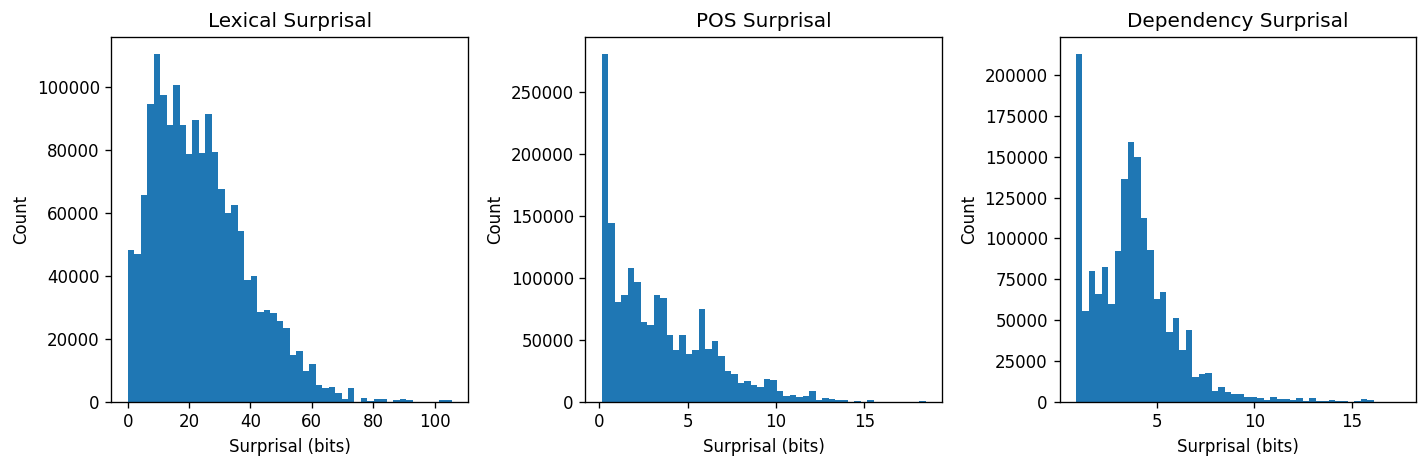

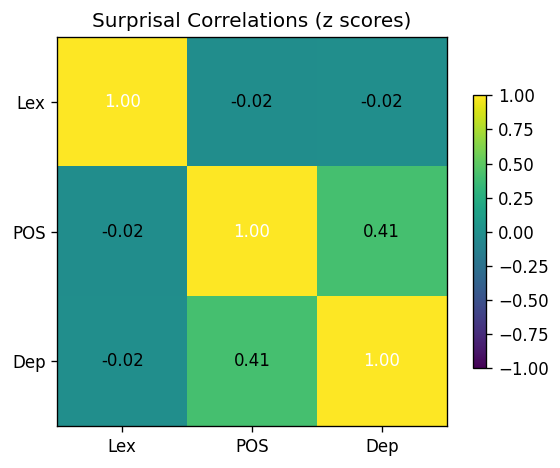

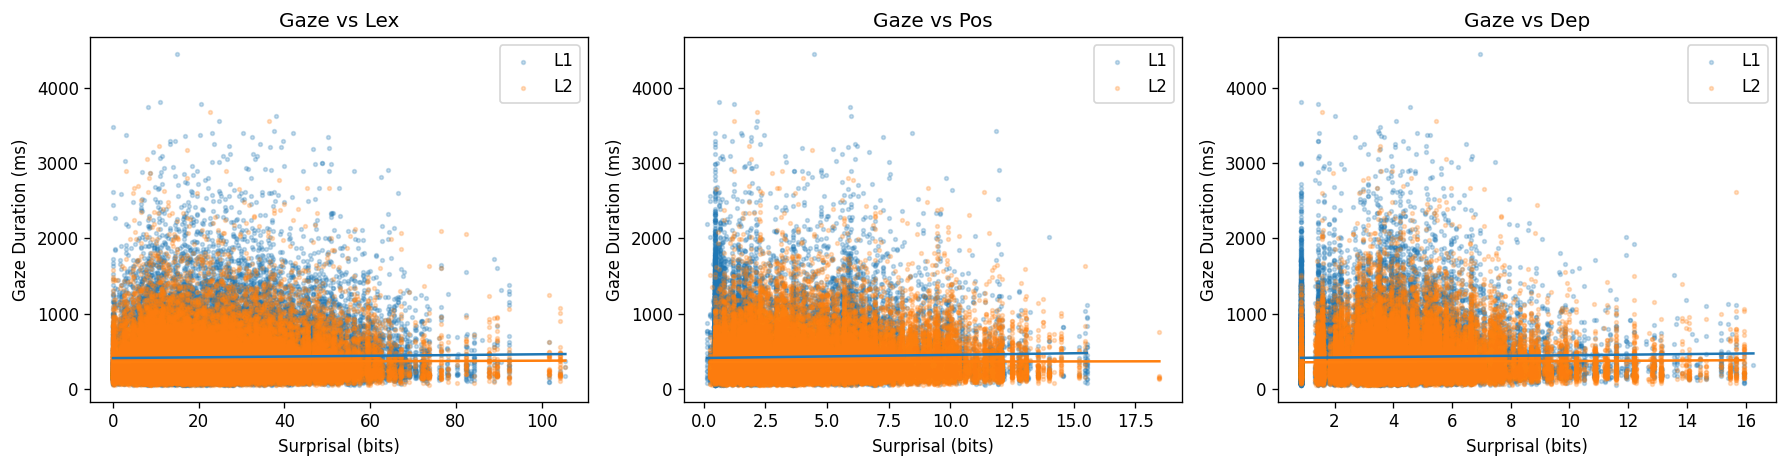

No MixedLM random effects available, skipping Figure D.


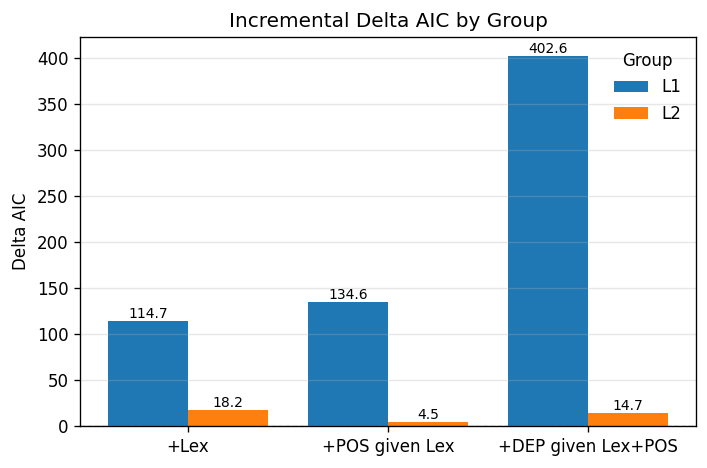

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure output folder exists
fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)
plt.rcParams["figure.dpi"] = 120

# Surprisal distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, col, title in zip(
    axes,
    ["surprisal_lex", "surprisal_pos", "surprisal_dep"],
    ["Lexical Surprisal", "POS Surprisal", "Dependency Surprisal"]
):
    x = pd.to_numeric(df[col], errors="coerce").dropna().astype("float32")
    ax.hist(x, bins=50)
    ax.set_title(title)
    ax.set_xlabel("Surprisal (bits)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(fig_dir / "figA_surprisal_dists.png", bbox_inches="tight")
plt.show()

# Correlation heatmap (compute z scores here)
def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    m = s.mean()
    v = s.std(ddof=0)
    if pd.notna(v) and np.isfinite(v) and v > 0:
        return (s - m) / v
    return pd.Series(np.zeros(len(s)), index=s.index)

corr_df = df[["surprisal_lex", "surprisal_pos", "surprisal_dep"]].copy().dropna()
corr_df = pd.DataFrame({
    "Lex": zscore(corr_df["surprisal_lex"]).astype("float32"),
    "POS": zscore(corr_df["surprisal_pos"]).astype("float32"),
    "Dep": zscore(corr_df["surprisal_dep"]).astype("float32"),
})
corr = corr_df.corr()

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(corr.values, vmin=-1, vmax=1)
ax.set_xticks(range(3)); ax.set_yticks(range(3))
ax.set_xticklabels(corr.columns); ax.set_yticklabels(corr.index)
for i in range(3):
    for j in range(3):
        val = corr.iat[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha="center", va="center",
                color="white" if abs(val) > 0.5 else "black")
fig.colorbar(im, ax=ax, shrink=0.7)
ax.set_title("Surprisal Correlations (z scores)")
plt.tight_layout()
plt.savefig(fig_dir / "figB_corr_heatmap.png", bbox_inches="tight")
plt.show()

# RT vs Surprisal (scatter plus linear fit, subsampled per group)
scatter_cols = ["gaze_dur", "surprisal_lex", "surprisal_pos", "surprisal_dep", "group"]
scatter_df = df[scatter_cols].copy().dropna()

def sample_group(gname, n=50000, seed=42):
    g = scatter_df[scatter_df["group"] == gname]
    if len(g) > n:
        return g.sample(n=n, random_state=seed)
    return g

s_L1 = sample_group("L1")
s_L2 = sample_group("L2")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ["surprisal_lex", "surprisal_pos", "surprisal_dep"]):
    for label, subset in [("L1", s_L1), ("L2", s_L2)]:
        x = pd.to_numeric(subset[col], errors="coerce").astype("float32")
        y = pd.to_numeric(subset["gaze_dur"], errors="coerce").astype("float32")
        ax.scatter(x, y, s=5, alpha=0.25, label=label)
        mask = x.notna() & y.notna()
        if mask.sum() > 1000:
            m, b = np.polyfit(x[mask], y[mask], 1)
            xs = np.linspace(float(x.min()), float(x.max()), 100)
            ax.plot(xs, m * xs + b)
    ax.set_title(f"Gaze vs {col.split('_')[1].capitalize()}")
    ax.set_xlabel("Surprisal (bits)")
    ax.set_ylabel("Gaze Duration (ms)")
    ax.legend()
plt.tight_layout()
plt.savefig(fig_dir / "figC_rt_vs_surprisal.png", bbox_inches="tight")
plt.show()

#Subject intercepts
print("No MixedLM random effects available, skipping Figure D.")

# Incremental Delta AIC bar chart (uses res from AIC cell)
if "res" in globals() and isinstance(res, pd.DataFrame) and not res.empty:
    # Prefer ASCII column names if present, else fall back to old delta columns
    if {"d_lex_vs_base", "d_pos_vs_lex", "d_dep_vs_lexpos"}.issubset(res.columns):
        keys = ["d_lex_vs_base", "d_pos_vs_lex", "d_dep_vs_lexpos"]
    else:
        keys = ["Δlex_vs_base", "Δpos_vs_lex", "Δdep_vs_lexpos"]

    plot_df = res.dropna(subset=keys).copy()
    labels = ["+Lex", "+POS given Lex", "+DEP given Lex+POS"]

    groups = sorted(plot_df["group"].dropna().unique())
    x = np.arange(len(keys))
    bar_w = 0.8 / max(len(groups), 1)

    fig, ax = plt.subplots(figsize=(6, 4))
    for i, grp in enumerate(groups):
        vals = plot_df[plot_df["group"] == grp][keys].mean().values
        pos = x + (i - (len(groups) - 1) / 2) * bar_w
        ax.bar(pos, vals, bar_w, label=grp)
        for p, v in zip(pos, vals):
            ax.text(p, v + 0.02, f"{v:.1f}", ha="center", va="bottom", fontsize="small")

    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_ylabel("Delta AIC")
    ax.set_title("Incremental Delta AIC by Group")
    ax.legend(title="Group", frameon=False)
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_dir / "figE_delta_aic.png", bbox_inches="tight")
    plt.show()
else:
    print("AIC results DataFrame 'res' not found or empty, skipping Figure E.")


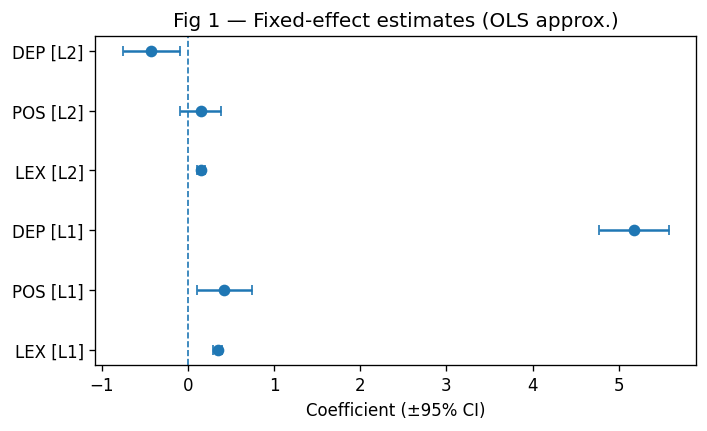

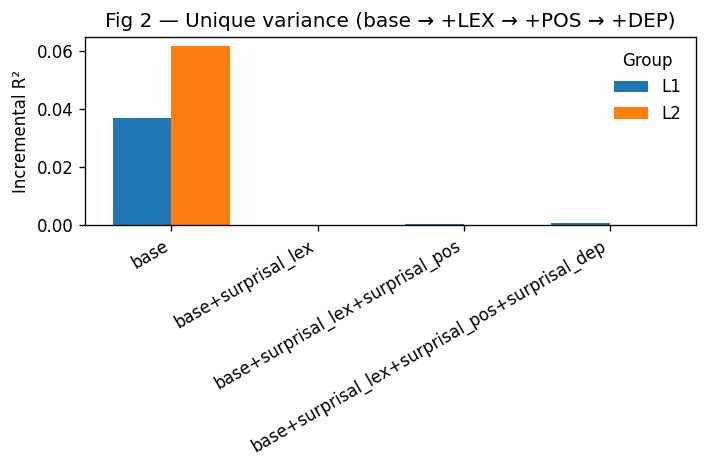

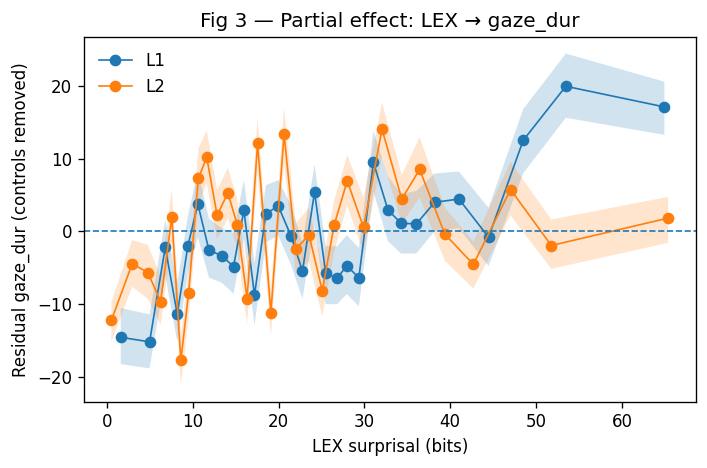

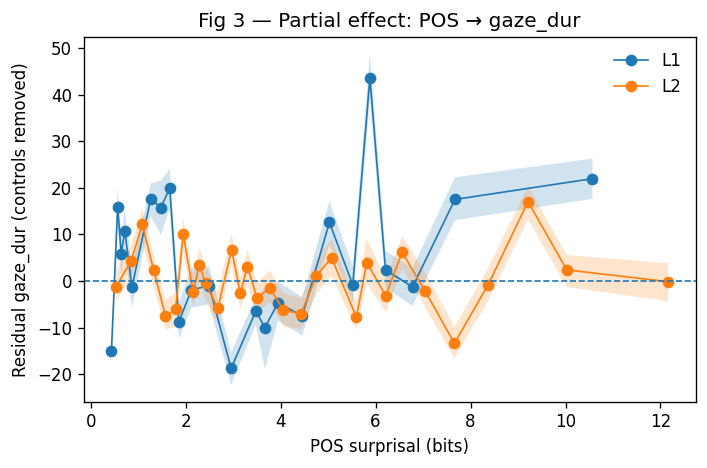

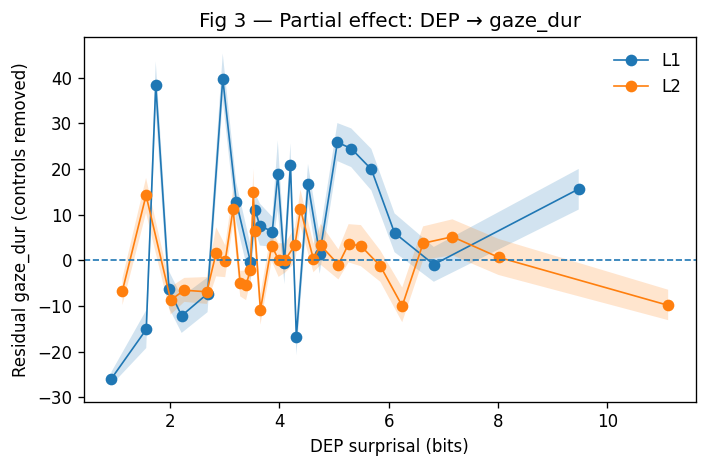

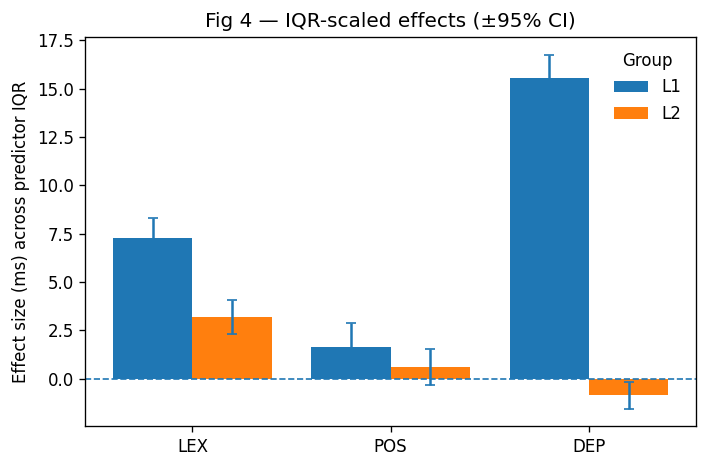

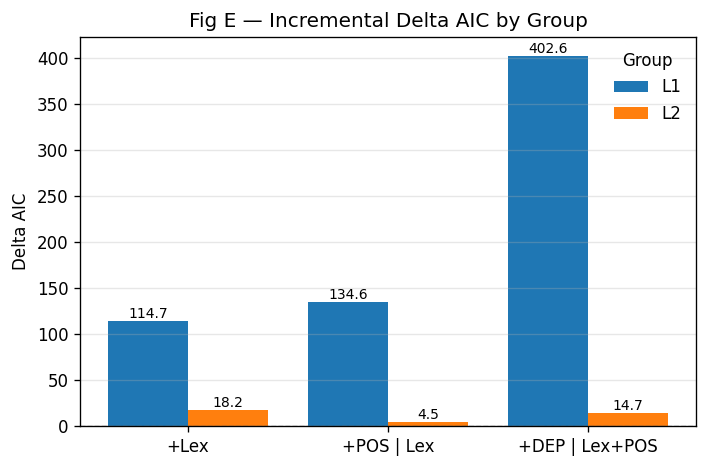

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RT_COL   = "gaze_dur"
GRP_COL  = "group"          # L1/L2
SUBJ_COL = "subj_id"        # random intercept FE approx when feasible
SURP_COLS = ["surprisal_lex","surprisal_pos","surprisal_dep"]
CONTROLS  = ["word_len","relative_position","is_content","log_freq"]  # will drop if missing

# Output dir
fig_dir = Path("figures")
fig_dir.mkdir(exist_ok=True)
plt.rcParams["figure.dpi"] = 120

# Helpers (Matplotlib + OLS only)
def _one_hot(s: pd.Series) -> pd.DataFrame:
    oh = pd.get_dummies(s.astype(str), prefix=s.name, dtype=float, sparse=True)
    try: oh = oh.sparse.to_dense()
    except: pass
    return oh

def build_design(df_in, y, predictors, controls=(), subject=None,
                 fe_cap=250, n_cap=1_200_000):
    yv = pd.to_numeric(df_in[y], errors="coerce").astype("float64")
    # keep only available controls
    use_ctrls = [c for c in controls if c in df_in.columns]
    Xcols, names = [], []
    for c in use_ctrls:
        Xcols.append(pd.to_numeric(df_in[c], errors="coerce").astype("float64").to_numpy())
        names.append(c)
    for p in predictors:
        Xcols.append(pd.to_numeric(df_in[p], errors="coerce").astype("float64").to_numpy())
        names.append(p)
    if subject and subject in df_in.columns and df_in[subject].nunique(dropna=True) <= fe_cap and len(df_in) <= n_cap:
        fe = _one_hot(df_in[subject]).to_numpy()
        if fe.shape[1] > 0:
            Xcols.append(fe); names += [f"{subject}={i}" for i in range(fe.shape[1])]
    X = np.column_stack(Xcols) if Xcols else np.zeros((len(df_in), 0))
    mask = np.isfinite(yv) & np.all(np.isfinite(X), axis=1)
    return X[mask], yv.to_numpy()[mask], names, mask

def ols_fit(X, y):
    X1 = np.c_[np.ones(len(X)), X]
    beta = np.linalg.lstsq(X1, y, rcond=None)[0]
    yhat = X1 @ beta
    resid = y - yhat
    n, p1 = X1.shape
    dof = max(n - p1, 1)
    sigma2 = (resid @ resid) / dof
    XtX_inv = np.linalg.pinv(X1.T @ X1)
    se_full = np.sqrt(np.diag(sigma2 * XtX_inv))
    return beta, se_full, yhat, resid

def residualize(df_in, y, controls=(), subject=None):
    X, yv, names, mask = build_design(df_in, y=y, predictors=[], controls=controls, subject=subject)
    if X.shape[1] == 0:
        return (yv - np.nanmean(yv)), mask
    beta, _, yhat, _ = ols_fit(X, yv)
    return (yv - yhat), mask

def partial_effect_data(df_in, x, y, controls=(), subject=None, bins=30, n_boot=400, seed=123):
    resid, mask = residualize(df_in, y=y, controls=controls, subject=subject)
    xv = pd.to_numeric(df_in.loc[df_in.index[mask], x], errors="coerce").astype("float64").to_numpy()
    rng = np.random.default_rng(seed)
    edges = np.unique(np.nanquantile(xv, np.linspace(0,1,bins+1)))
    idx = np.digitize(xv, edges[1:-1], right=True)
    tmp = pd.DataFrame({"bin": idx, "x": xv, "resid": resid})
    g = tmp.groupby("bin")
    cx = g["x"].mean().to_numpy()
    my = g["resid"].mean().to_numpy()
    lo, hi = [], []
    for _, gi in g:
        arr = gi["resid"].dropna().to_numpy()
        if len(arr) < 3: lo.append(np.nan); hi.append(np.nan); continue
        boots = [rng.choice(arr, size=len(arr), replace=True).mean() for _ in range(n_boot)]
        lo.append(np.nanpercentile(boots, 2.5)); hi.append(np.nanpercentile(boots, 97.5))
    order = np.argsort(cx)
    return cx[order], my[order], np.array(lo)[order], np.array(hi)[order]

def r2_from_fit(y_true, y_hat):
    ss_res = np.sum((y_true - y_hat)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else 0.0

def incremental_r2(df_in, y, base_controls, add_terms, subject=None):
    # lock a common mask for fairness
    cols_needed = [c for c in base_controls if c in df_in.columns] + list(add_terms) + [y]
    m = np.ones(len(df_in), dtype=bool)
    for c in cols_needed:
        m &= np.isfinite(pd.to_numeric(df_in[c], errors="coerce"))
    sub = df_in.loc[m]
    Xb, yv, _, _ = build_design(sub, y=y, predictors=[], controls=base_controls, subject=subject)
    if Xb.shape[1] == 0:
        yhat = np.repeat(yv.mean(), len(yv))
    else:
        _, _, yhat, _ = ols_fit(Xb, yv)
    r2_vals = [("base", r2_from_fit(yv, yhat))]
    X_curr = Xb
    for t in add_terms:
        xt = pd.to_numeric(sub[t], errors="coerce").astype("float64").to_numpy().reshape(-1,1)
        X_curr = np.hstack([X_curr, xt])
        _, _, yhat, _ = ols_fit(X_curr, yv)
        r2_vals.append((r2_vals[-1][0] + f"+{t}", r2_from_fit(yv, yhat)))
    return r2_vals

# Groups
groups = sorted(df[GRP_COL].dropna().unique()) if GRP_COL in df.columns else ["ALL"]

# Fig 1 — Forest (±95% CI)
rows = []
for g in groups:
    sub = df if g=="ALL" or GRP_COL not in df.columns else df[df[GRP_COL]==g]
    X, yv, names, _ = build_design(sub, y=RT_COL, predictors=SURP_COLS, controls=CONTROLS, subject=SUBJ_COL)
    if X.shape[0] < 100 or X.shape[1] < 1: continue
    beta, se_full, *_ = ols_fit(X, yv)
    b = beta[1:1+X.shape[1]]; se = se_full[1:1+X.shape[1]]
    p = len(SURP_COLS)
    for i, term in enumerate(SURP_COLS):
        rows.append({"group": g, "term": term, "est": b[-p+i], "se": se[-p+i]})
if rows:
    tab = pd.DataFrame(rows)
    tab["lo"] = tab["est"] - 1.96*tab["se"]
    tab["hi"] = tab["est"] + 1.96*tab["se"]
    labels = tab["term"].str.replace("surprisal_","").str.upper() + " [" + tab["group"].astype(str) + "]"
    order = np.arange(len(tab))[::-1]
    fig = plt.figure(figsize=(6, 0.45*len(tab)+1)); ax = fig.add_subplot(111)
    ax.errorbar(tab["est"].to_numpy()[order], order,
                xerr=1.96*tab["se"].to_numpy()[order], fmt="o", capsize=3)
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_yticks(order); ax.set_yticklabels(labels.iloc[order].tolist())
    ax.set_xlabel("Coefficient (±95% CI)")
    ax.set_title("Fig 1 — Fixed-effect estimates (OLS approx.)")
    fig.tight_layout()
    fig.savefig(fig_dir / "Fig1_forest.png", bbox_inches="tight")
    plt.show()
else:
    print("Fig1: Not enough data — skipped.")

# Fig 2  Incremental R^2 (unique variance)
add_order = [t for t in ["surprisal_lex","surprisal_pos","surprisal_dep"] if t in SURP_COLS]
if add_order:
    all_vals = {}
    for g in groups:
        sub = df if g=="ALL" or GRP_COL not in df.columns else df[df[GRP_COL]==g]
        steps = incremental_r2(sub, y=RT_COL, base_controls=CONTROLS, add_terms=add_order, subject=SUBJ_COL)
        vals = [v for _, v in steps]
        deltas = [vals[0]] + [vals[i]-vals[i-1] for i in range(1,len(vals))]
        all_vals[g] = (steps, deltas)
    keys = [k for k,_ in next(iter(all_vals.values()))[0]]
    x = np.arange(len(keys)); bar_w = 0.8 / len(all_vals)
    fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(111)
    for i, (g, (_, deltas)) in enumerate(all_vals.items()):
        pos = x + (i - (len(all_vals)-1)/2)*bar_w
        ax.bar(pos, deltas, bar_w, label=str(g))
    ax.set_xticks(x); ax.set_xticklabels(keys, rotation=30, ha="right")
    ax.set_ylabel("Incremental R²")
    ax.set_title("Fig 2 — Unique variance (base → +LEX → +POS → +DEP)")
    ax.legend(frameon=False, title="Group")
    fig.tight_layout()
    fig.savefig(fig_dir / "Fig2_deltaR2.png", bbox_inches="tight")
    plt.show()
else:
    print("Fig2: No predictors — skipped.")

# Partial-effect curves (L1 vs L2) + 95% CI
for pred in SURP_COLS:
    fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(111)
    for g in groups:
        sub = df if g=="ALL" or GRP_COL not in df.columns else df[df[GRP_COL]==g]
        cx, my, lo, hi = partial_effect_data(sub, x=pred, y=RT_COL,
                                             controls=CONTROLS, subject=SUBJ_COL,
                                             bins=30, n_boot=400, seed=123)
        ax.plot(cx, my, marker="o", linewidth=1, label=str(g))
        ax.fill_between(cx, lo, hi, alpha=0.2)
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xlabel(pred.replace("surprisal_","").upper() + " surprisal (bits)")
    ax.set_ylabel(f"Residual {RT_COL} (controls removed)")
    ax.set_title(f"Fig 3 — Partial effect: {pred.replace('surprisal_','').upper()} → {RT_COL}")
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(fig_dir / f"Fig3_partial_{pred}.png", bbox_inches="tight")
    plt.show()

# IQR-scaled effects in ms (with 95% CI)
rows = []
for g in groups:
    sub = df if g=="ALL" or GRP_COL not in df.columns else df[df[GRP_COL]==g]
    X, yv, names, _ = build_design(sub, y=RT_COL, predictors=SURP_COLS, controls=CONTROLS, subject=SUBJ_COL)
    if X.shape[0] < 100 or X.shape[1] < 1: continue
    beta, se_full, *_ = ols_fit(X, yv)
    b = beta[1:1+X.shape[1]]; se = se_full[1:1+X.shape[1]]
    p = len(SURP_COLS)
    coef = b[-p:]; se_pred = se[-p:]
    for i, pred in enumerate(SURP_COLS):
        xvals = pd.to_numeric(sub[pred], errors="coerce").astype("float64")
        iqr = np.nanpercentile(xvals, 75) - np.nanpercentile(xvals, 25)
        est = coef[i] * iqr
        ci = 1.96 * se_pred[i] * iqr
        rows.append({"group": g, "term": pred, "effect_ms": est, "lo": est-ci, "hi": est+ci})
if rows:
    tab = pd.DataFrame(rows)
    x = np.arange(len(SURP_COLS))
    bar_w = 0.8 / len(groups)
    fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(111)
    for i, g in enumerate(groups):
        tsub = tab[tab["group"]==g]
        pos = x + (i - (len(groups)-1)/2)*bar_w
        ax.bar(pos, tsub["effect_ms"].to_numpy(), bar_w, label=str(g))
        yerr = np.vstack([tsub["effect_ms"].to_numpy() - tsub["lo"].to_numpy(),
                          tsub["hi"].to_numpy() - tsub["effect_ms"].to_numpy()])
        ax.errorbar(pos, tsub["effect_ms"].to_numpy(), yerr=yerr, fmt="none", capsize=3)
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xticks(x); ax.set_xticklabels([t.replace("surprisal_","").upper() for t in SURP_COLS])
    ax.set_ylabel("Effect size (ms) across predictor IQR")
    ax.set_title("Fig 4 — IQR-scaled effects (±95% CI)")
    ax.legend(frameon=False, title="Group")
    fig.tight_layout()
    fig.savefig(fig_dir / "Fig4_effect_sizes.png", bbox_inches="tight")
    plt.show()
else:
    print("Fig4: Not enough data — skipped.")

# Fig E — Incremental
if "res" in globals() and isinstance(res, pd.DataFrame) and not res.empty:
    if {"d_lex_vs_base", "d_pos_vs_lex", "d_dep_vs_lexpos"}.issubset(res.columns):
        keys = ["d_lex_vs_base", "d_pos_vs_lex", "d_dep_vs_lexpos"]
    else:
        keys = [k for k in ["Δlex_vs_base","Δpos_vs_lex","Δdep_vs_lexpos"] if k in res.columns]
    if len(keys) == 3:
        plot_df = res.dropna(subset=keys).copy()
        labels = ["+Lex", "+POS | Lex", "+DEP | Lex+POS"]
        groups_res = sorted(plot_df["group"].dropna().unique()) if "group" in plot_df.columns else ["ALL"]
        x = np.arange(len(keys)); bar_w = 0.8 / max(len(groups_res), 1)
        fig, ax = plt.subplots(figsize=(6, 4))
        for i, grp in enumerate(groups_res):
            vals = plot_df[plot_df["group"] == grp][keys].mean().values if grp!="ALL" else plot_df[keys].mean().values
            pos = x + (i - (len(groups_res) - 1) / 2) * bar_w
            ax.bar(pos, vals, bar_w, label=grp)
            for p, v in zip(pos, vals):
                ax.text(p, v + 0.02, f"{v:.1f}", ha="center", va="bottom", fontsize="small")
        ax.set_xticks(x); ax.set_xticklabels(labels)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_ylabel("Delta AIC")
        ax.set_title("Fig E — Incremental Delta AIC by Group")
        ax.legend(title="Group", frameon=False)
        ax.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig(fig_dir / "FigE_delta_aic.png", bbox_inches="tight")
        plt.show()
    else:
        print("FigE: AIC table found but missing required delta columns.")
else:
    print("FigE: No AIC table `res` — skipped.")


Save result tables safe and complete

In [14]:
# save result to tables

import pandas as pd
from pathlib import Path

tables_dir = Path("tables")
tables_dir.mkdir(exist_ok=True, parents=True)

# Interaction parameters from the lexical only model (fit_int)
#    Saves a single column CSV with parameter estimates if fit_int exists.
if "fit_int" in globals() and hasattr(fit_int, "params"):
    params = getattr(fit_int, "params")
    if isinstance(params, (pd.Series, pd.DataFrame)):
        out = params if isinstance(params, pd.DataFrame) else params.to_frame(name="Estimate")
        out.to_csv(tables_dir / "interaction_params_lex_only.csv")
        print("Wrote tables/interaction_params_lex_only.csv")
    else:
        print("fit_int.params is not a pandas object, skipping interaction params export.")
else:
    print("fit_int not found, skipping interaction params export.")

# Delta AIC nested model results from earlier summary (variable 'results')
#    Accepts a dict of dicts or a DataFrame and writes it to CSV.
if "results" in globals():
    if isinstance(results, dict):
        pd.DataFrame(results).T.to_csv(tables_dir / "delta_aic_nested_lexposdep.csv")
        print("Wrote tables/delta_aic_nested_lexposdep.csv")
    elif isinstance(results, pd.DataFrame):
        results.to_csv(tables_dir / "delta_aic_nested_lexposdep.csv", index=False)
        print("Wrote tables/delta_aic_nested_lexposdep.csv")
    else:
        print("Variable 'results' is not dict or DataFrame, skipping delta AIC export.")
else:
    print("Variable 'results' not found, skipping delta AIC export.")

print("Base tables saved to:", str(tables_dir.resolve()))
print("Additional tables will be saved by later cells.")


fit_int not found, skipping interaction params export.
Variable 'results' not found, skipping delta AIC export.
Base tables saved to: /content/tables
Additional tables will be saved by later cells.


Ensure control features are present

In [15]:
import numpy as np
from collections import Counter

# Add word length if it is not already in the data frame
if 'word_len' not in df.columns:
    df['word_len'] = df['word_clean'].astype(str).str.len()

# Recompute content/function flag based on POS tags
# Heuristic: treat tokens whose Penn tag starts with N, V, J, R or is 'CD' as content words
if 'pos' in df.columns:
    tags = df['pos'].astype(str)
    df['is_content'] = (
        tags.str.startswith(('N', 'V', 'J', 'R')) |
        (tags == 'CD')
    ).astype(int)
else:
    # if POS not available, leave previous flag or default to 1
    df['is_content'] = df.get('is_content', 1)

# Create a log frequency proxy if no external frequencies were merged
if 'log_freq' not in df.columns:
    # count each lower-cased word across the corpus
    words = df['word_clean'].astype(str).str.lower().fillna('')
    freq_counts = Counter(words)
    df['log_freq'] = words.map(freq_counts).astype(float).pipe(np.log1p)

# Report which columns were added or verified
print('Verified columns:',
      'word_len'       , 'OK' if 'word_len'   in df.columns else 'MISSING',
      'is_content'     , 'OK' if 'is_content' in df.columns else 'MISSING',
      'log_freq'       , 'OK' if 'log_freq'   in df.columns else 'MISSING')


Verified columns: word_len OK is_content OK log_freq OK


Prepare lagged surprisal and standardize predictors with diagnostics

In [16]:
import numpy as np
import pandas as pd

# For each surprisal type, compute the previous token’s surprisal within each sentence
for base in ["surprisal_lex", "surprisal_pos", "surprisal_dep"]:
    prev_col = base + "_prev"
    # make sure rows are in reading order
    df = df.sort_values(["subj_id", "text_id", "sent_id", "ia_id"])
    # shift by one within each sentence
    df[prev_col] = df.groupby(["subj_id", "text_id", "sent_id"])[base].shift(1)

# Define a safe z-scoring function that returns zeros if the standard deviation is zero
def zscore_safe(series):
    numeric = pd.to_numeric(series, errors="coerce")
    mean = numeric.mean()
    std = numeric.std(ddof=0)
    if not np.isfinite(std) or std == 0:
        return pd.Series(0.0, index=numeric.index)
    return (numeric - mean) / std

# Apply z-scoring to all core predictors
predictors = [
    "surprisal_lex", "surprisal_pos", "surprisal_dep",
    "surprisal_lex_prev", "surprisal_pos_prev", "surprisal_dep_prev",
    "word_len", "relative_position", "is_content", "log_freq"
]
for col in predictors:
    if col in df.columns:
        df[col + "_z"] = zscore_safe(df[col])

# Identify which reading-time columns we will use
rt_columns = [c for c in ["gaze_dur", "first_run_dur", "reg_path"] if c in df.columns]
print("Reading time columns available:", rt_columns)

# Diagnostics for interaction models:
# Count how many rows have no missing values for all required predictors
required = [
    "surprisal_lex_z", "surprisal_pos_z", "surprisal_dep_z",
    "word_len_z", "relative_position_z", "is_content_z", "log_freq_z",
    "group", "subj_id"
]
for rt in rt_columns:
    needed = [rt] + required
    valid = df[needed].notna().all(axis=1).sum()
    print(f"Rows with complete data for interaction with {rt}:", valid)

# Show non-missing counts for each required column
counts = df[rt_columns + required].notna().sum().sort_values()
print("\nNon-missing counts by column:")
print(counts)


Reading time columns available: ['gaze_dur', 'first_run_dur', 'reg_path']
Rows with complete data for interaction with gaze_dur: 1248176
Rows with complete data for interaction with first_run_dur: 1248979
Rows with complete data for interaction with reg_path: 897942

Non-missing counts by column:
reg_path                904169
gaze_dur               1293911
first_run_dur          1294696
surprisal_lex_z        1695777
surprisal_pos_z        1708955
surprisal_dep_z        1708955
relative_position_z    1708955
word_len_z             1756640
is_content_z           1756640
log_freq_z             1756640
group                  1756640
subj_id                1756640
dtype: int64


modeling helper functions

In [17]:
# Modeling Helpers
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

def fit_ols_clustered(data, formula, cluster_col='subj_id'):
    """OLS with cluster-robust SE by subject."""
    m = smf.ols(formula, data=data).fit(
        cov_type='cluster',
        cov_kwds={'groups': data[cluster_col]}
    )
    coefs = (
        m.summary2().tables[1]
         .rename(columns={'Coef.':'coef','Std.Err.':'se','P>|t|':'p',
                          '[0.025':'ci_low','0.975]':'ci_high'})
         .reset_index().rename(columns={'index':'term'})
    )
    return m, coefs

def fit_mixedlm(data, formula, group_col='subj_id'):
    """
    MixedLM with random intercepts AND random slopes for all surprisal terms.
    Formula must include surprisal_lex_z, surprisal_pos_z, surprisal_dep_z.
    """
    try:
        md = smf.mixedlm(
            formula,
            data=data,
            groups=data[group_col],
            re_formula="1 + surprisal_lex_z + surprisal_pos_z + surprisal_dep_z"
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            fit = md.fit(method='lbfgs', reml=False, maxiter=200, disp=False)
        params = fit.params
        conf   = fit.conf_int()
        cov    = fit.cov_params()
        rows = []
        for term, coef in params.items():
            se = np.sqrt(cov.loc[term, term]) if term in cov.index else np.nan
            ci_low, ci_high = conf.loc[term].tolist() if term in conf.index else (np.nan, np.nan)
            rows.append({
                'term': term,
                'coef': coef,
                'se': se,
                'ci_low': ci_low,
                'ci_high': ci_high,
                'p': np.nan
            })
        coefs = pd.DataFrame(rows)
        return fit, coefs
    except Exception as e:
        print("MixedLM failed:", e)
        return None, None

def lr_test(model_small, model_large):
    """Likelihood-ratio test for nested models."""
    lr_stat = 2 * (model_large.llf - model_small.llf)
    df_diff = int(model_large.df_model - model_small.df_model)
    p_value = chi2.sf(lr_stat, max(df_diff, 1))
    return {'lr': lr_stat, 'df': df_diff, 'p': p_value}

def r2_increment_table(models, labels):
    """Table of AIC, BIC, and adjusted R2 for nested models."""
    rows = []
    for lbl, m in zip(labels, models):
        rows.append({
            'model': lbl,
            'AIC': getattr(m, 'aic',       np.nan),
            'BIC': getattr(m, 'bic',       np.nan),
            'R2_adj': getattr(m, 'rsquared_adj', np.nan)
        })
    return pd.DataFrame(rows)


Modeling and reporting helper functions

In [18]:
# Modeling Helpers with Random Slopes in MixedLM

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import chi2

def fit_ols_clustered(data, formula, cluster_col='subj_id'):
    """
    Fit ordinary least squares with cluster-robust SE by subject.
    Returns (fitted_model, coefficient_table).
    coefficient_table has columns: term, coef, se, p, ci_low, ci_high.
    """
    m = smf.ols(formula, data=data).fit(
        cov_type='cluster',
        cov_kwds={'groups': data[cluster_col]}
    )
    coefs = (
        m.summary2()
         .tables[1]
         .rename(columns={
             'Coef.':   'coef',
             'Std.Err.': 'se',
             'P>|t|':   'p',
             '[0.025':  'ci_low',
             '0.975]':  'ci_high'
         })
         .reset_index()
         .rename(columns={'index': 'term'})
    )
    return m, coefs

def fit_mixedlm(data, formula, group_col='subj_id'):
    """
    Fit a mixed linear model with random intercepts AND random slopes
    for all surprisal predictors. Returns (fit, coef_table) or (None, None) on failure.
    """
    try:
        # re_formula controls which slopes vary by subject
        md = smf.mixedlm(formula,
                         data=data,
                         groups=data[group_col],
                         re_formula="~ surprisal_lex_z + surprisal_pos_z + surprisal_dep_z")
        fit = md.fit(method='lbfgs', reml=False, maxiter=200, disp=False)
        params = fit.params
        conf   = fit.conf_int()
        cov    = fit.cov_params()
        rows = []
        for term, coef in params.items():
            se = np.sqrt(cov.loc[term, term]) if term in cov.index else np.nan
            if term in conf.index:
                ci_low, ci_high = conf.loc[term].tolist()
            else:
                ci_low = ci_high = np.nan
            rows.append({
                'term':   term,
                'coef':   coef,
                'se':     se,
                'ci_low': ci_low,
                'ci_high':ci_high,
                'p':      np.nan
            })
        coef_table = pd.DataFrame(rows)
        return fit, coef_table
    except Exception as e:
        print("MixedLM failed:", e)
        return None, None

def lr_test(model_small, model_large):
    """
    Likelihood-ratio test for nested models.
    Returns dict with keys: lr, df, p.
    """
    lr_stat = 2 * (model_large.llf - model_small.llf)
    df_diff = int(model_large.df_model - model_small.df_model)
    p_val   = chi2.sf(lr_stat, max(df_diff,1))
    return {'lr': lr_stat, 'df': df_diff, 'p': p_val}

def r2_increment_table(models, labels):
    """
    Build a table of AIC, BIC, and adjusted R2 for a sequence of nested models.
    Returns a DataFrame with columns: model, AIC, BIC, R2_adj.
    """
    rows = []
    for label, m in zip(labels, models):
        rows.append({
            'model':  label,
            'AIC':    getattr(m, 'aic',    np.nan),
            'BIC':    getattr(m, 'bic',    np.nan),
            'R2_adj': getattr(m, 'rsquared_adj', np.nan)
        })
    return pd.DataFrame(rows)


Run interaction and nested models, spillover, and export results

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# This cell relies on the helper functions defined above:
#   fit_ols_clustered, fit_mixedlm, lr_test, r2_increment_table

# Create output folder for tables
tables_dir = Path("tables")
tables_dir.mkdir(exist_ok=True, parents=True)

# Configuration for skipping sparse conditions
MIN_ROWS_OVERALL = 500
MIN_ROWS_PER_GROUP = 50
MIN_SUBJECTS = 2
RUN_MIXEDLM = True

def ok_to_run(subdf):
    """
    Decide whether to run clustered OLS (if enough rows and subjects),
    or fallback to plain OLS.
    """
    if len(subdf) < MIN_ROWS_PER_GROUP:
        return False
    if subdf['subj_id'].nunique() < MIN_SUBJECTS:
        return 'few_subjects'
    return True

# Identify which reaction time columns to use
rt_candidates = [c for c in ['gaze_dur', 'first_run_dur', 'reg_path'] if c in df.columns]
rt_cols = []
for rt in rt_candidates:
    valid = df[rt].notna().sum()
    if valid >= MIN_ROWS_OVERALL:
        rt_cols.append(rt)
    else:
        print(f"Skipping {rt}: only {valid} valid rows")

if not rt_cols:
    raise RuntimeError("No RT columns have enough data")

# Interaction across L1 vs L2
interaction_results = []
mixedlm_results = []

controls = 'word_len_z + relative_position_z + is_content_z + log_freq_z'
terms = [
    'surprisal_lex_z', 'surprisal_pos_z', 'surprisal_dep_z',
    'is_L2',
    'surprisal_lex_z:is_L2',
    'surprisal_pos_z:is_L2',
    'surprisal_dep_z:is_L2',
    controls
]
formula_base = ' + '.join(terms)

print("Running interaction models")
for rt in rt_cols:
    subset = df.dropna(subset=[rt, 'surprisal_lex_z', 'surprisal_pos_z',
                                'surprisal_dep_z', 'word_len_z',
                                'relative_position_z', 'is_content_z',
                                'log_freq_z', 'group', 'subj_id'])
    subset['is_L2'] = (subset['group'].str.upper() == 'L2').astype(int)
    if len(subset) < MIN_ROWS_OVERALL:
        print(f"{rt} skipped: only {len(subset)} rows")
        continue
    formula = f"np.log({rt} + 1e-3) ~ {formula_base}"
    run_type = ok_to_run(subset)
    # clustered OLS or plain OLS
    try:
        if run_type is True:
            m, coefs = fit_ols_clustered(subset, formula)
        else:
            m = smf.ols(formula, data=subset).fit()
            coefs = (
                m.summary2()
                .tables[1]
                .rename(columns={'Coef.':'coef','Std.Err.':'se','P>|t|':'p',
                                 '[0.025':'ci_low','0.975]':'ci_high'})
                .reset_index()
                .rename(columns={'index':'term'})
            )
        coefs['rt'] = rt
        coefs['model'] = 'interaction_clustered' if run_type is True else 'interaction_plain'
        interaction_results.append(coefs)
        print(f"{rt} OLS done, n={len(subset)}, subjects={subset['subj_id'].nunique()}")
    except Exception as e:
        print(f"{rt} OLS error: {e}")

    # optionally run MixedLM
    if RUN_MIXEDLM:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=UserWarning)
            warnings.simplefilter('ignore', category=ConvergenceWarning)
            m_mx, coefs_mx = fit_mixedlm(subset, formula)
        if coefs_mx is not None:
            coefs_mx['rt'] = rt
            coefs_mx['model'] = 'interaction_mixedlm'
            mixedlm_results.append(coefs_mx)
            print(f"{rt} MixedLM converged")
        else:
            print(f"{rt} MixedLM failed or did not converge")

# Save interaction results
if interaction_results:
    pd.concat(interaction_results, ignore_index=True).to_csv(
        tables_dir / 'coefs_interaction.csv', index=False)
if mixedlm_results:
    pd.concat(mixedlm_results, ignore_index=True).to_csv(
        tables_dir / 'coefs_interaction_mixedlm.csv', index=False)

# Groupwise nested models with LR tests and R2
nested_rows = []
r2_tables = []

print("Running groupwise nested models")
for rt in rt_cols:
    for grp in ['L1', 'L2']:
        group_data = df[df['group'] == grp].dropna(subset=[rt, 'word_len_z',
                                                           'relative_position_z',
                                                           'is_content_z',
                                                           'log_freq_z',
                                                           'surprisal_lex_z',
                                                           'surprisal_pos_z',
                                                           'surprisal_dep_z',
                                                           'subj_id'])
        run_type = ok_to_run(group_data)
        if not run_type:
            print(f"{rt} {grp} skipped, n={len(group_data)}")
            continue

        y = f"np.log({rt} + 1e-3)"
        base = f"{y} ~ word_len_z + relative_position_z + is_content_z + log_freq_z"
        try:
            if run_type is True:
                m0, _ = fit_ols_clustered(group_data, base)
                m1, _ = fit_ols_clustered(group_data, base + " + surprisal_lex_z")
                m2, _ = fit_ols_clustered(group_data, base + " + surprisal_lex_z + surprisal_pos_z")
                m3, _ = fit_ols_clustered(group_data, base + " + surprisal_lex_z + surprisal_pos_z + surprisal_dep_z")
            else:
                m0 = smf.ols(base, data=group_data).fit()
                m1 = smf.ols(base + " + surprisal_lex_z", data=group_data).fit()
                m2 = smf.ols(base + " + surprisal_lex_z + surprisal_pos_z", data=group_data).fit()
                m3 = smf.ols(base + " + surprisal_lex_z + surprisal_pos_z + surprisal_dep_z", data=group_data).fit()

            # likelihood ratio tests
            lr01 = lr_test(m0, m1)
            lr12 = lr_test(m1, m2)
            lr23 = lr_test(m2, m3)
            for step, lr in zip(['Base->LEX','LEX->POS','POS->DEP'], [lr01, lr12, lr23]):
                nested_rows.append({'rt': rt, 'group': grp, 'step': step, **lr})

            # R2 increment table
            r2tab = r2_increment_table([m0, m1, m2, m3],
                                       ['Base','Base+LEX','Base+LEX+POS','Full'])
            r2tab['rt'] = rt
            r2tab['group'] = grp
            r2_tables.append(r2tab)

            print(f"{rt} {grp} nested models done")
        except Exception as e:
            print(f"{rt} {grp} nested error: {e}")

# save nested results
if nested_rows:
    pd.DataFrame(nested_rows).to_csv(tables_dir / 'lrtests_groupwise.csv', index=False)
if r2_tables:
    pd.concat(r2_tables, ignore_index=True).to_csv(
        tables_dir / 'r2_steps_groupwise.csv', index=False)

# Spillover analysis: previous-word surprisal
spill_rows = []
spill_coefs = []

print("Running spillover models")
for rt in rt_cols:
    for grp in ['L1', 'L2']:
        data_grp = df[df['group'] == grp].dropna(subset=[rt,
            'word_len_z','relative_position_z','is_content_z','log_freq_z',
            'surprisal_lex_prev_z','surprisal_pos_prev_z','surprisal_dep_prev_z',
            'subj_id'])
        run_type = ok_to_run(data_grp)
        if not run_type:
            print(f"{rt} {grp} spillover skipped, n={len(data_grp)}")
            continue

        y = f"np.log({rt} + 1e-3)"
        base = f"{y} ~ word_len_z + relative_position_z + is_content_z + log_freq_z"
        try:
            if run_type is True:
                m0, _ = fit_ols_clustered(data_grp, base)
                m1, _ = fit_ols_clustered(data_grp, base + " + surprisal_lex_prev_z")
                m2, _ = fit_ols_clustered(data_grp, base + " + surprisal_lex_prev_z + surprisal_pos_prev_z")
                m3, coefs3 = fit_ols_clustered(data_grp,
                    base + " + surprisal_lex_prev_z + surprisal_pos_prev_z + surprisal_dep_prev_z")
            else:
                # plain OLS fallback
                m0 = smf.ols(base, data=data_grp).fit()
                m1 = smf.ols(base + " + surprisal_lex_prev_z", data=data_grp).fit()
                m2 = smf.ols(base + " + surprisal_lex_prev_z + surprisal_pos_prev_z", data=data_grp).fit()
                m3 = smf.ols(base + " + surprisal_lex_prev_z + surprisal_pos_prev_z + surprisal_dep_prev_z", data=data_grp).fit()
                coefs3 = (
                    m3.summary2()
                    .tables[1]
                    .rename(columns={'Coef.':'coef','Std.Err.':'se','P>|t|':'p',
                                     '[0.025':'ci_low','0.975]':'ci_high'})
                    .reset_index()
                    .rename(columns={'index':'term'})
                )

            coefs3['rt'] = rt
            coefs3['group'] = grp
            coefs3['model'] = 'spillover_full_prev'
            spill_coefs.append(coefs3)

            lr01 = lr_test(m0, m1)
            lr12 = lr_test(m1, m2)
            lr23 = lr_test(m2, m3)
            for step, lr in zip(['Base->LEXprev','LEXprev->POSprev','POSprev->DEPprev'],
                                 [lr01, lr12, lr23]):
                spill_rows.append({'rt': rt, 'group': grp, 'step': step, **lr})

            print(f"{rt} {grp} spillover done")
        except Exception as e:
            print(f"{rt} {grp} spillover error: {e}")

# save spillover results
if spill_rows:
    pd.DataFrame(spill_rows).to_csv(tables_dir / 'lrtests_spillover.csv', index=False)
if spill_coefs:
    pd.concat(spill_coefs, ignore_index=True).to_csv(
        tables_dir / 'coefs_spillover_full.csv', index=False)

# Save key interaction coefficients
try:
    key = pd.read_csv(tables_dir / 'coefs_interaction.csv')
    terms = ['surprisal_lex_z','surprisal_pos_z','surprisal_dep_z',
             'surprisal_lex_z:is_L2','surprisal_pos_z:is_L2','surprisal_dep_z:is_L2']
    key2 = key[key['term'].isin(terms)].copy()
    key2 = key2.rename(columns={'coef':'beta','se':'std_err','p':'p_value'})
    key2.sort_values(['rt','term'], inplace=True)
    key2.to_csv(tables_dir / 'coefs_key_interaction.csv', index=False)
    print("Saved key interaction coefficients")
except Exception as e:
    print("Error saving key coefficients:", e)

print("All analyses complete. Tables are in", tables_dir)


Running interaction models


/tmp/ipython-input-2216818047.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['is_L2'] = (subset['group'].str.upper() == 'L2').astype(int)


gaze_dur OLS done, n=1248176, subjects=825


/tmp/ipython-input-1590927451.py:51: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(cov.loc[term, term]) if term in cov.index else np.nan


gaze_dur MixedLM converged


/tmp/ipython-input-2216818047.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['is_L2'] = (subset['group'].str.upper() == 'L2').astype(int)


first_run_dur OLS done, n=1248979, subjects=825
first_run_dur MixedLM converged


/tmp/ipython-input-2216818047.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['is_L2'] = (subset['group'].str.upper() == 'L2').astype(int)


reg_path OLS done, n=897942, subjects=825
reg_path MixedLM converged
Running groupwise nested models
gaze_dur L1 nested models done
gaze_dur L2 nested models done
first_run_dur L1 nested models done
first_run_dur L2 nested models done
reg_path L1 nested models done
reg_path L2 nested models done
Running spillover models
gaze_dur L1 spillover done
gaze_dur L2 spillover done
first_run_dur L1 spillover done
first_run_dur L2 spillover done
reg_path L1 spillover done
reg_path L2 spillover done
Saved key interaction coefficients
All analyses complete. Tables are in tables


In [20]:
# Print all result tables to screen

import pandas as pd
from pathlib import Path

# directory where the tables were saved
tables_dir = Path("tables")

# list of result files to print
result_files = [
    "coefs_interaction.csv",
    "coefs_interaction_mixedlm.csv",
    "lrtests_groupwise.csv",
    "r2_steps_groupwise.csv",
    "lrtests_spillover.csv",
    "coefs_spillover_full.csv",
    "coefs_key_interaction.csv"
]

for fname in result_files:
    fpath = tables_dir / fname
    print(f"\n=== {fname} ===")
    if fpath.exists():
        df = pd.read_csv(fpath)
        # print entire table
        print(df.to_string(index=False))
    else:
        print("File not found:", fpath)



=== coefs_interaction.csv ===
                 term      coef       se          z         P>|z|    ci_low   ci_high            rt                 model
            Intercept  5.760963 0.015370 374.817009  0.000000e+00  5.730838  5.791088      gaze_dur interaction_clustered
      surprisal_lex_z  0.010353 0.001050   9.861483  6.113967e-23  0.008295  0.012410      gaze_dur interaction_clustered
      surprisal_pos_z  0.000186 0.002013   0.092317  9.264461e-01 -0.003759  0.004130      gaze_dur interaction_clustered
      surprisal_dep_z  0.021991 0.002595   8.473147  2.388509e-17  0.016904  0.027078      gaze_dur interaction_clustered
                is_L2 -0.055950 0.017987  -3.110661  1.866692e-03 -0.091203 -0.020697      gaze_dur interaction_clustered
surprisal_lex_z:is_L2 -0.006458 0.001528  -4.226435  2.374229e-05 -0.009453 -0.003463      gaze_dur interaction_clustered
surprisal_pos_z:is_L2 -0.000491 0.002102  -0.233540  8.153418e-01 -0.004610  0.003629      gaze_dur interaction_clu

In [21]:
# MECO L1/L2 dataset summary and RT measure availability

import pandas as pd

# try to reuse already loaded frames, otherwise load from disk
try:
    l1
    l2
except NameError:
    l1 = pd.read_csv("data/meco_l1.csv")
    l2 = pd.read_csv("data/meco_l2.csv")

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def choose_paragraph_key(df):
    # prefer uniform_id, then itemid, then trialid
    return pick_col(df, ["uniform_id", "itemid", "trialid"])

def count_tokens(df):
    if "word" in df.columns:
        return int(df["word"].notna().sum())
    return int(len(df))

# subject id columns picked per dataset
subj_l1 = pick_col(l1, ["subid", "subj_id", "participant", "Participant", "subject", "subject_id"])
subj_l2 = pick_col(l2, ["subid", "subj_id", "participant", "Participant", "subject", "subject_id"])

participants_L1 = l1[subj_l1].nunique() if subj_l1 else None
participants_L2 = l2[subj_l2].nunique() if subj_l2 else None

# paragraphs and union across sets
para_key_l1 = choose_paragraph_key(l1)
para_key_l2 = choose_paragraph_key(l2)

paragraphs_L1 = l1[para_key_l1].nunique() if para_key_l1 else None
paragraphs_L2 = l2[para_key_l2].nunique() if para_key_l2 else None

if para_key_l1 and para_key_l2:
    paragraphs_union = pd.concat(
        [
            l1[[para_key_l1]].rename(columns={para_key_l1: "pid"}),
            l2[[para_key_l2]].rename(columns={para_key_l2: "pid"}),
        ],
        ignore_index=True,
    )["pid"].dropna().nunique()
else:
    paragraphs_union = None

total_tokens = count_tokens(l1) + count_tokens(l2)

# reading time measures with multiple name variants
candidate_map = {
    "gaze_dur": ["gaze_dur", "dur"],
    "first_run_dur": ["first_run_dur", "firstrun.dur"],
    "reg_path": ["reg_path", "gopast", "firstrun.gopast", "firstrun.gopast.sel"],
    "first_fix_dur": ["firstfix.dur", "first_fix_dur"],
    "single_fix_dur": ["singlefix.dur", "single_fix_dur"],
}

def measures_present(df):
    found = {}
    for logical, candidates in candidate_map.items():
        col = pick_col(df, candidates)
        if col:
            found[logical] = col
    return found

measures_L1 = measures_present(l1)
measures_L2 = measures_present(l2)

# common logical measures present in both sets
common_keys = sorted(set(measures_L1).intersection(measures_L2))
common_measures = {k: (measures_L1[k], measures_L2[k]) for k in common_keys}
common_source_cols = sorted(set([measures_L1[k] for k in common_keys] + [measures_L2[k] for k in common_keys]))

print("Participants L1:", participants_L1, "(col", subj_l1 or "missing", ")")
print("Participants L2:", participants_L2, "(col", subj_l2 or "missing", ")")

print("Paragraph key L1:", para_key_l1)
print("Paragraph key L2:", para_key_l2)
print("Paragraphs L1:", paragraphs_L1)
print("Paragraphs L2:", paragraphs_L2)
print("Paragraphs union:", paragraphs_union)

print("Total tokens:", total_tokens)

print("Measures L1:", measures_L1)
print("Measures L2:", measures_L2)
print("Common measures:", {k: v[0] if v[0] == v[1] else v for k, v in common_measures.items()})

# paper sentence template
if paragraphs_union is not None and participants_L1 is not None and participants_L2 is not None:
    print(
        f"\nPaper sentence template:\n"
        f"MECO L1 includes {participants_L1} participants and MECO L2 includes {participants_L2}. "
        f"Both groups read {paragraphs_union} paragraphs in total, spanning {total_tokens} tokens. "
        f"We analyze {', '.join(common_keys)} "
        f"with source columns {', '.join(common_source_cols)}."
    )


Participants L1: 654 (col subj_id )
Participants L2: 659 (col subj_id )
Paragraph key L1: uniform_id
Paragraph key L2: uniform_id
Paragraphs L1: 654
Paragraphs L2: 659
Paragraphs union: 770
Total tokens: 1756337
Measures L1: {'gaze_dur': 'gaze_dur', 'first_run_dur': 'first_run_dur', 'reg_path': 'reg_path', 'first_fix_dur': 'firstfix.dur', 'single_fix_dur': 'singlefix.dur'}
Measures L2: {'gaze_dur': 'gaze_dur', 'first_run_dur': 'first_run_dur', 'reg_path': 'reg_path', 'first_fix_dur': 'firstfix.dur', 'single_fix_dur': 'singlefix.dur'}
Common measures: {'first_fix_dur': 'firstfix.dur', 'first_run_dur': 'first_run_dur', 'gaze_dur': 'gaze_dur', 'reg_path': 'reg_path', 'single_fix_dur': 'singlefix.dur'}

Paper sentence template:
MECO L1 includes 654 participants and MECO L2 includes 659. Both groups read 770 paragraphs in total, spanning 1756337 tokens. We analyze first_fix_dur, first_run_dur, gaze_dur, reg_path, single_fix_dur with source columns first_run_dur, firstfix.dur, gaze_dur, reg_